## AdaBoost Model

In [55]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, f1_score

## Load Data

In [9]:
df = pd.read_csv('./data/reddit_df.csv')
df.dropna(inplace=True)
df.reset_index(inplace=True,drop=True)

In [10]:
X = df['title']
y = df['real']

In [11]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    stratify=y,
                                                    random_state=42)

## Baseline Accuracy

In [12]:
y.value_counts(normalize=True)

1    0.508027
0    0.491973
Name: real, dtype: float64

## AdaBoost

In [41]:
pipe = Pipeline([
    ('cvec',CountVectorizer()),
    ('sc',StandardScaler(with_mean=False)),
    ('ada',AdaBoostClassifier())
])
pipe_params = {
    'cvec__max_features':[3_000],
    'cvec__min_df'      :[3],
    'cvec__max_df'      :[.9],
    'cvec__ngram_range' :[(1,1)],
    'ada__learning_rate':[1,0.5],
    'ada__n_estimators' :[400,600]
}
gs_ada = GridSearchCV(pipe,param_grid = pipe_params, cv=5)

In [42]:
gs_ada.fit(X_train,y_train);

In [43]:
print('Train score', cross_val_score(pipe,X_train,y_train,cv=10).mean())
print('Test score', gs_ada.score(X_test,y_test))
y_pred = gs_ada.predict(X_test)
print('f1 score',f1_score(y_test,y_pred))

Train score 0.7160956065211385
Test score 0.7955665024630542
f1 score 0.7896070975918885


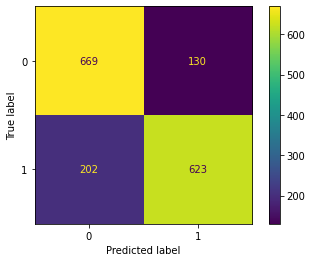

In [44]:
plot_confusion_matrix(gs_ada,X_test,y_test)

In [45]:
gs_ada.best_params_

{'ada__learning_rate': 0.5,
 'ada__n_estimators': 600,
 'cvec__max_df': 0.9,
 'cvec__max_features': 3000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1)}

## Important Features

In [46]:
pipe = Pipeline([
    ('cvec',CountVectorizer(max_df=0.9,max_features=3000,min_df=2,ngram_range=(1,1))),
    ('sc',StandardScaler(with_mean=False)),
    ('ada',AdaBoostClassifier(learning_rate=0.5,n_estimators=600))
])
pipe.fit(X_train,y_train);

In [50]:
# Retrieve the coefficients, turn into dataframe, and show the largest coefficient
coef = pipe.named_steps['ada'].feature_importances_
coef_df = pd.DataFrame({'coefs':coef},index=pipe.named_steps['cvec'].get_feature_names())
coef_df.nlargest(10,'coefs')

,coefs
us,0.020000
california,0.010000
covid19,0.008333
school,0.008333
shot,0.008333
state,0.008333
arrested,0.006667
died,0.006667
dies,0.006667
killed,0.006667


The AdaBoost model perform slightly better than RandomForest Model, worse than Naive Bayes model. 